## Setting up the env variables

In [1]:
# Import Azure OpenAI
from langchain.llms import AzureOpenAI
from langchain.chains import LLMChain
from dotenv import load_dotenv
load_dotenv("../../.env")
from langchain.chat_models import AzureChatOpenAI

## Intent chain - (Intent Skill)

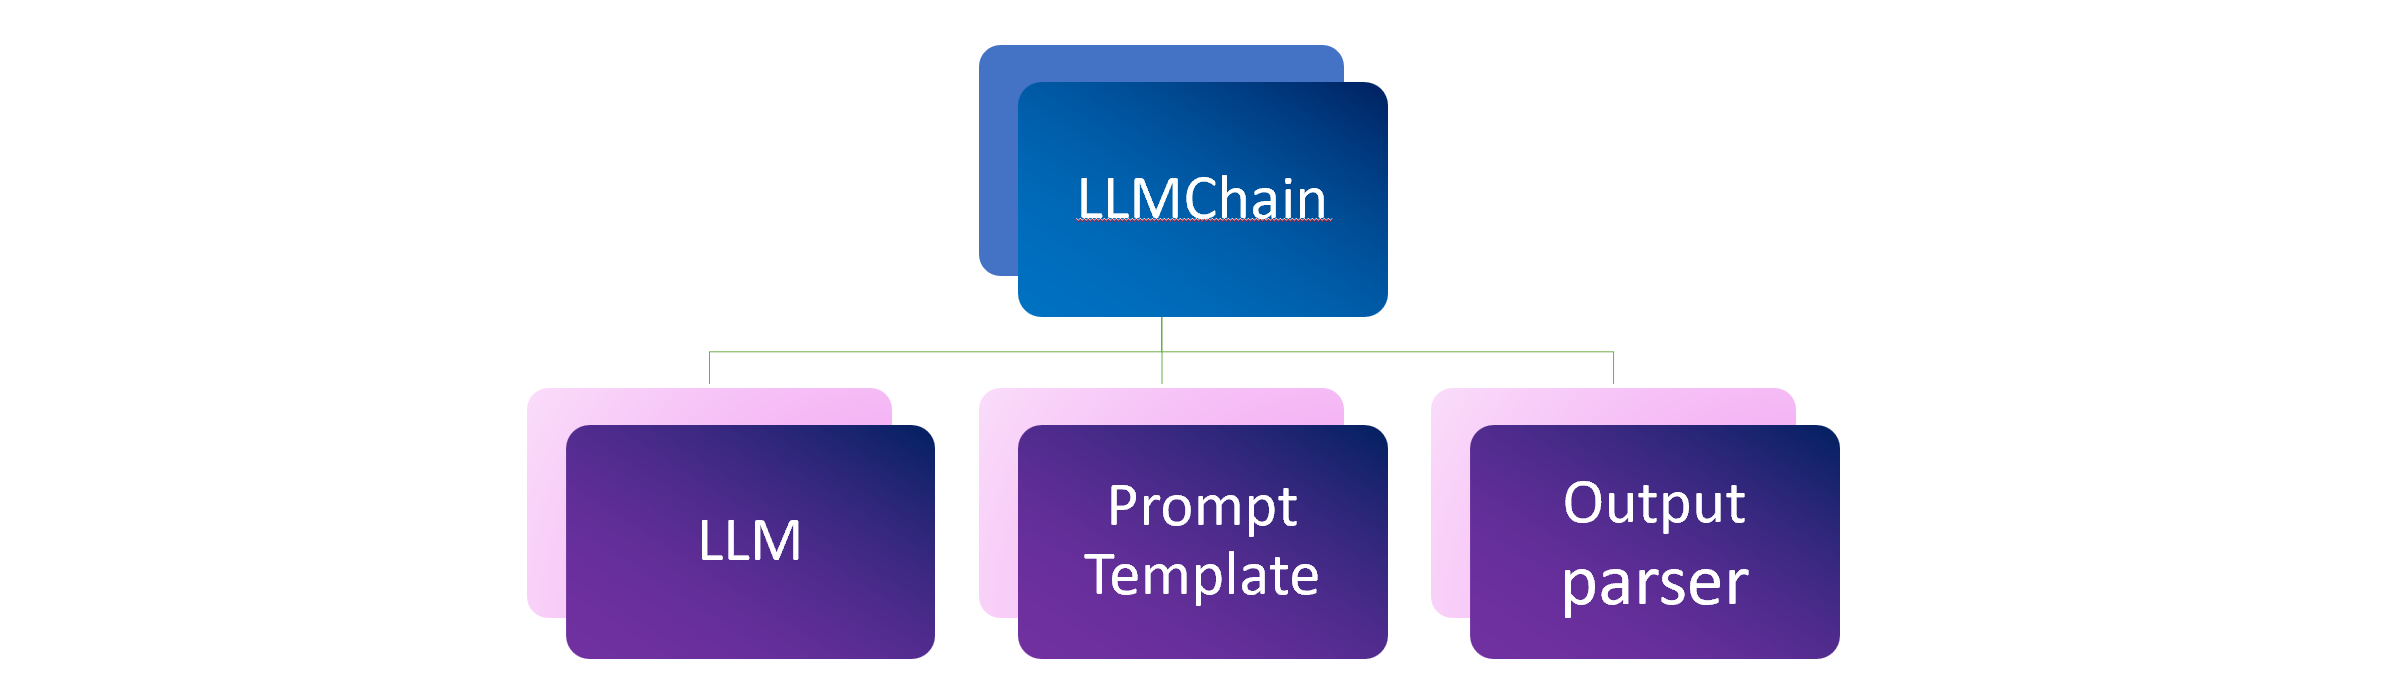

In [2]:
from langchain.schema import BaseOutputParser
from langchain.prompts import PromptTemplate

# Output parser - Parses the output of the LLM call to transform the output in desired format.
class IntentOutputParser(BaseOutputParser):
    """Parse the output of an LLM call to a comma-separated list."""

    def parse(self, text: str):
        """Parse the output of an LLM call."""
        intents = ["GET PARKING SPOT", "GET REGISTRATION DETAILS"]
        for i in intents:
            if i in text:
                return i
        return "INTENT UNCLEAR"

# Prompt template for the chain
prompt_template = PromptTemplate.from_template("""You are a helpful assistant that identifies the intent of a user's query. 
There are 2 possible intents - GET PARKING SPOT, GET REGISTRATION DETAILS. 
Choose the most appropriate intent based on the human's query.
What is the intent for the following ask? 
{ask}
""")

llm = AzureOpenAI(
    deployment_name="completion-gpt-35-turbo",
    model_name="gpt-35-turbo",
    temperature=0.0
)

# Defining the chain
intent_chain = LLMChain(
    llm=llm, 
    prompt=prompt_template, 
    output_parser=IntentOutputParser(), 
    verbose=True
)

In [3]:
intent_chain.run("Where should I park my car?")



> Entering new LLMChain chain...
Prompt after formatting:
You are a helpful assistant that identifies the intent of a user's query. 
There are 2 possible intents - GET PARKING SPOT, GET REGISTRATION DETAILS. 
Choose the most appropriate intent based on the human's query.
What is the intent for the following ask? 
Where should I park my car?


> Finished chain.


'GET PARKING SPOT'

### Creating a few shot prompt template - for a chat interface

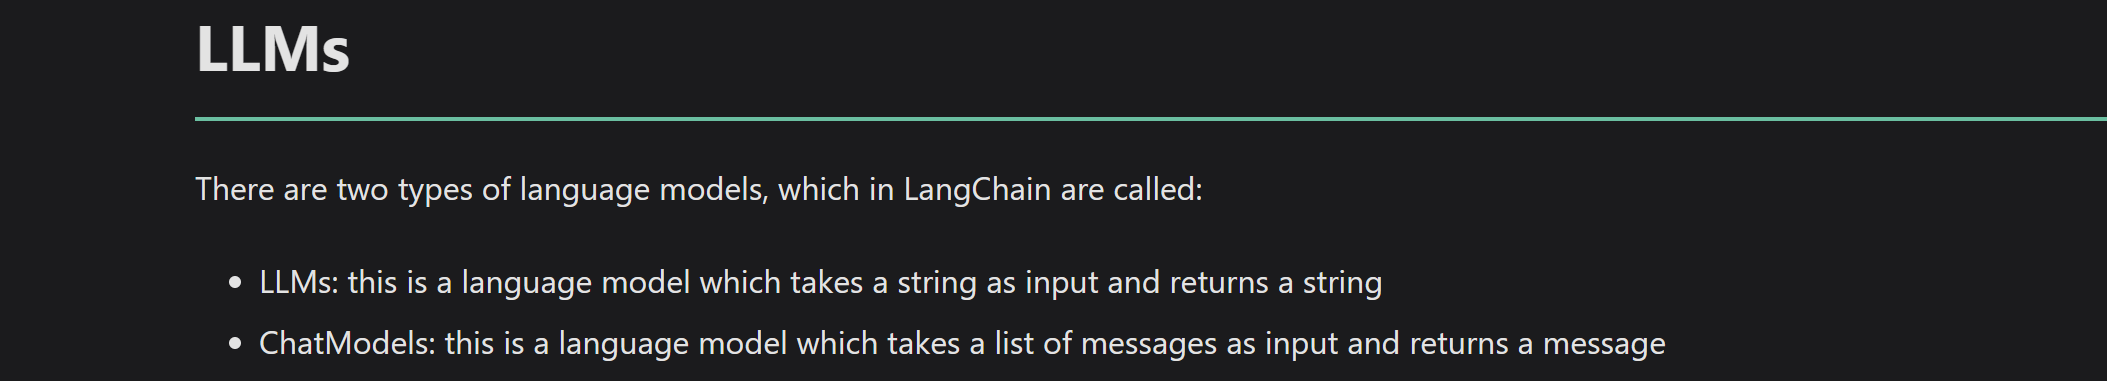

In [4]:
from langchain.prompts.chat import (
    ChatPromptTemplate
)
from langchain.prompts import FewShotChatMessagePromptTemplate

# Example input and output pairs
intent_identification_examples = [
    {"input": "Find me the nearest parking spot.", "output": "GET PARKING SPOT"},
    {"input": "Do you have the registration details of my vehicle?", "output": "GET REGISTRATION DETAILS"},
    {"input": "Where can I park my vehicle?", "output": "GET PARKING SPOT"},
    {"input": "Give me the registration details.", "output": "GET REGISTRATION DETAILS"}
]

# This is a prompt template used to format each individual example.
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)

# Creating the few shot prompt
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=intent_identification_examples,
)

# Final prompt template
final_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", 
         """You are a helpful assistant that identifies the intent of a user's query. 
         There are 2 possible intents - GET PARKING SPOT, GET REGISTRATION DETAILS. 
         Choose the most appropriate intent based on the human's query. 
         Here are some examples for you to understand how to output the intent."""
         ),
        few_shot_prompt,
        ("human", "{input}\nAI: "),
    ]
)

llm = AzureChatOpenAI(
    deployment_name="completion-gpt-35-turbo",
    model_name="gpt-35-turbo",
    temperature=0.0
)
intent_chain = LLMChain(
    llm=llm, 
    prompt=final_prompt, 
    # output_parser=IntentOutputParser(), 
    verbose=True
    )

In [5]:
intent_chain.run("Get the registeration details")



> Entering new LLMChain chain...
Prompt after formatting:
System: You are a helpful assistant that identifies the intent of a user's query. 
         There are 2 possible intents - GET PARKING SPOT, GET REGISTRATION DETAILS. 
         Choose the most appropriate intent based on the human's query. 
         Here are some examples for you to understand how to output the intent.
Human: Find me the nearest parking spot.
AI: GET PARKING SPOT
Human: Do you have the registration details of my vehicle?
AI: GET REGISTRATION DETAILS
Human: Where can I park my vehicle?
AI: GET PARKING SPOT
Human: Give me the registration details.
AI: GET REGISTRATION DETAILS
Human: Get the registeration details
AI: 

> Finished chain.


'GET REGISTRATION DETAILS'

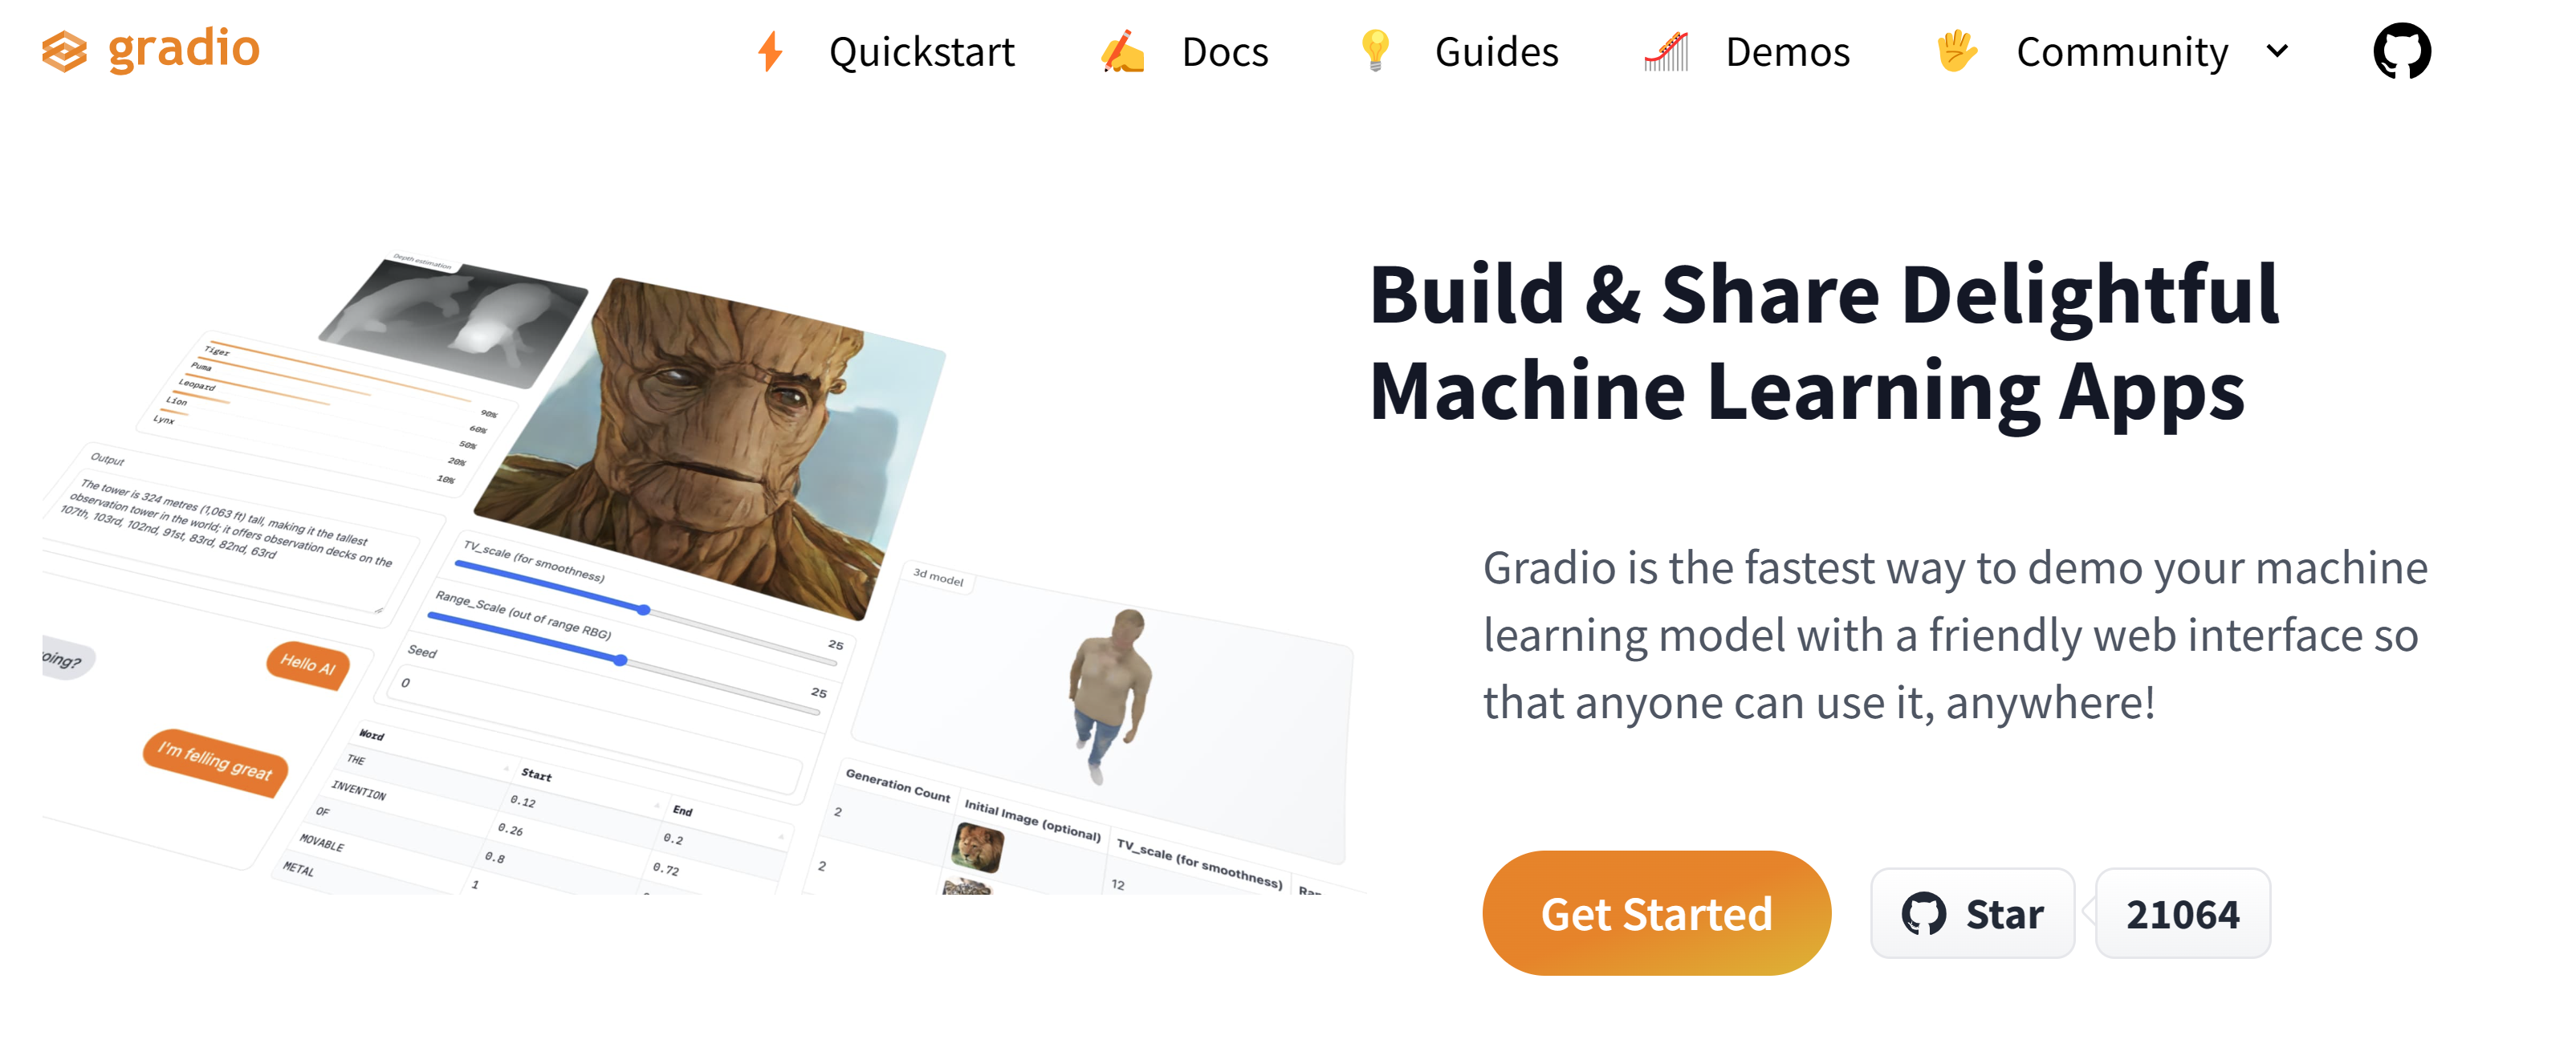

### Using gradio to demo the intent skill

In [6]:
import gradio as gr

def intent_chain_func(query):
    ans = intent_chain.run(query)
    return f"{ans}"

demo_intent_chain = gr.Interface(
    fn=intent_chain_func,
    inputs=["text"],
    outputs=["text"],
    title="Intent Recognizer"
)
demo_intent_chain.launch()

c:\Users\dsanghvi\Work\langchain\langchain_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


## Fetch user vehicle details

In [7]:
# Fetching the vehicle details for the user
import pandas as pd

def get_vehicle_details_string(row):
    values = list(row)
    indices = row.index
    st = ""
    for a,b in list(zip(indices, values)):
        st += a + "-->" + b
        st += ", "
    return st

def fetch_vehicle_details_from_live_database(user):
    df_vehicle_details = pd.read_csv("./data/VehicleDetails.csv")
    df_user_vehicle = df_vehicle_details[df_vehicle_details["Employee"] == user]
    if len(df_user_vehicle) == 0:
        "NO REGISTERED VEHICLE FOUND"
    else:
        return get_vehicle_details_string(df_user_vehicle.iloc[0,:])

In [8]:
import gradio as gr

demo = gr.Interface(
    fn=fetch_vehicle_details_from_live_database,
    inputs=["text"],
    outputs=["text"],
    title="Get vehicle details"
)
demo.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


## Fetch available parking spots

In [9]:
# Fetching the vehicle details for the user
import pandas as pd

def get_building_num(row):
    return row["Outlook/Building Name"]

def fetch_available_parking_spots_in_building(building):
    df_available_space = pd.read_csv("./data/AvailableSpace.csv")
    df_available_space = df_available_space[df_available_space["Building Number"] == building]
    if len(df_available_space) == 0:
        "NO PARKING SPOT FOUND"
    else:
        return list(df_available_space["Parking Spot Number"])

## Wrapping everything together - Using an agent

In [10]:
from langchain.tools import Tool
from langchain.agents import create_csv_agent, AgentType, initialize_agent

def intent_recognizer_api(query: str) -> str:
    """Identifies the intent of the user's query"""
    ans = intent_chain.run(query)
    return ans

def get_employee_vehicle_details_api(user: str) -> str:
    """Returns the vehicle details for any employee. """
    ans = fetch_vehicle_details_from_live_database(user)
    return ans

def fetch_parking_spots_in_building_api(building_name: str) -> str:
    """There is a database containing all the available parking spots. This function performs a lookup on the database to identify the available parking spots in a specific building"""
    ans = fetch_available_parking_spots_in_building(building_name)
    # EXPLORE THIS AFTER THE SESSION. CREATES A CSV AGENT TO TALK TO A CSV FILE.
    # agent = create_csv_agent(
    #     llm,
    #     "./data/AvailableSpace.csv",
    #     verbose=True,
    #     agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    # )
    # ans = agent.run(f"Get me all the available parking spots in building {building_name}")
    return ans

def ask_user_for_clarification_api(query_for_user: str) -> str:
    """Asks the user for any required information/input."""
    input_from_user = input()
    return input_from_user

#### Defining tools from the functions

In [11]:
# Provide a function, name and description. The description will be used by the LLM to choose the correct tool.
t1 = Tool.from_function(
        func=intent_recognizer_api,
        name="get_intent_for_the_users_ask",
        description="Identifies the intent for the users ask"
)

t2 = Tool.from_function(
        func=get_employee_vehicle_details_api,
        name="get_employee_vehicle_details",
        description="Returns the employee, thier building details and their vehicle details given the user's name"
)

t3 = Tool.from_function(
        func=fetch_parking_spots_in_building_api,
        name="fetch_available_parking_spots_in_building",
        description="Performs a lookup on the database to identify the available parking spots in a specific building."
)

t4 = Tool.from_function(
        func=ask_user_for_clarification_api,
        name="ask_user_for_clarification",
        description="Asks the user for any required information/input."
)

#### Initializing the agent

In [12]:
# Initializing the agent
agent = initialize_agent(
        [t2, t3, t4], 
    llm, 
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, 
    verbose=True
)

In [13]:
agent.run("Help me find a parking spot")



> Entering new AgentExecutor chain...
I need to know which building the user is in and if they have a vehicle registered
Action: get_employee_vehicle_details
Action Input: user's name
Observation: None
Thought:If the user's name is not found, I need to ask for clarification
Action: ask_user_for_clarification
Action Input: "I'm sorry, I couldn't find your name. Can you please provide more information?"
Observation: Ananya
Thought:Now that I have the user's name, I need to check which building they are in
Action: get_employee_vehicle_details
Action Input: Ananya
Observation: Employee-->Ananya, Vehicle Type-->Car, Outlook/Building Name-->Building 8, Fuel Type-->Electric, Registration type-->Personal, Licenseplatenumber-->MAT231481, Reserved Parking-->Expectant Mother, 
Thought:Now that I know the building name, I need to fetch the available parking spots in that building
Action: fetch_available_parking_spots_in_building
Action Input: Building 8
Observation: ['PQ12128', 'PQ12134', 'PQ121

'"Your parking spot, PQ12148, has been reserved. Thank you for using our service!"'

In [15]:
agent.run("Whats my vehicle type?")



> Entering new AgentExecutor chain...
I need to retrieve the employee and vehicle details for the current user.
Action: get_employee_vehicle_details
Action Input: Current user's name
Observation: None
Thought:I need to check if the employee and vehicle details were successfully retrieved.
Action: get_employee_vehicle_details
Action Input: Current user's name
Observation: None
Thought:If the employee and vehicle details were successfully retrieved, I can return the vehicle type.
Action: get_employee_vehicle_details
Action Input: Current user's name
Observation: None
Thought:I need to check if the vehicle type is included in the retrieved details.
Action: get_employee_vehicle_details
Action Input: Current user's name
Observation: None
Thought:If the vehicle type is included in the retrieved details, I can return it as the final answer. If not, I need to ask the user for clarification.
Action: get_employee_vehicle_details or ask_user_for_clarification
Action Input: Current user's name o

'The final answer is the vehicle type for the current user, retrieved using the get_employee_vehicle_details tool after asking for clarification if necessary.'